## Timeseries Clustering - Indonesian Rainfall Type Classification

**Import libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.clustering import TimeSeriesKMeans
import netCDF4 as nc
import scipy.stats as st
import math

C:\Users\198003\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\198003\Anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:23: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


**Read data**

In [2]:
data = nc.Dataset('test_data.nc') #Monthly average ERA5 data 1998 - 2015
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2021-03-30 17:38:22 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data4/adaptor.mars.internal-1617125863.942012-21349-9-9cc9981d-a24b-4e4c-9ab2-de73a0515864.nc /cache/tmp/9cc9981d-a24b-4e4c-9ab2-de73a0515864-adaptor.mars.internal-1617125863.9434144-21349-4-tmp.grib
    dimensions(sizes): longitude(185), latitude(53), time(120)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 tp(time, latitude, longitude)
    groups: 

**Get the variables**

In [3]:
prec = data.variables['tp'][:]*1000
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]

In [4]:
prec.shape

(120, 53, 185)

**Get random samples from each region (5 region)**

In [5]:
#Sumatera
sumatera_data = prec[:,0:43,0:41] # -5.5 to 5.0 and 95.0 to 105.0
#Java, Bali and Nusa Tenggara
jabatra_data = prec[:,43:53,44:110] # -8.0 to -5.75 and 106 to 122.25
#Kalimantan
borneo_data = prec[:,12:36,56:93] # -3.75 to 2.0 and 109 to 118
#Sulawesi
celebes_data = prec[:,14:44,94:121] # -5.75 to 1.5 and 118.5 to 125
#Papua and Maluku
papmal_data = prec[:,10:53,125:184] # -8.0 to 2.5 and 126.25 to 140.75

In [6]:
sumatera = np.mean(sumatera_data.reshape(10,12,sumatera_data.shape[1],sumatera_data.shape[2]),axis=0)
jabatra = np.mean(jabatra_data.reshape(10,12,jabatra_data.shape[1],jabatra_data.shape[2]),axis=0)
borneo = np.mean(borneo_data.reshape(10,12,borneo_data.shape[1],borneo_data.shape[2]),axis=0)
celebes = np.mean(celebes_data.reshape(10,12,celebes_data.shape[1],celebes_data.shape[2]),axis=0)
papmal = np.mean(papmal_data.reshape(10,12,papmal_data.shape[1],papmal_data.shape[2]),axis=0)

In [7]:
def sample_size(n,prop,conf_level,moe):
    a = ((st.norm.ppf(1-(1-conf_level)/2)**2)*(prop*(1-prop)))/(moe**2)
    b = 1 + (((st.norm.ppf(1-(1-conf_level)/2)**2)*(prop*(1-prop)))/((moe**2)*n))
    
    return math.ceil(a/b)

In [8]:
samp_sumatra = sample_size(sumatera.shape[1]*sumatera.shape[2],0.5,0.95,0.05)
samp_jabatra = sample_size(jabatra.shape[1]*jabatra.shape[2],0.5,0.95,0.05)
samp_borneo = sample_size(borneo.shape[1]*borneo.shape[2],0.5,0.95,0.05)
samp_celebes = sample_size(celebes.shape[1]*celebes.shape[2],0.5,0.95,0.05)
samp_papmal = sample_size(papmal.shape[1]*papmal.shape[2],0.5,0.95,0.05)

In [9]:
print("Total sample size: ",str(samp_sumatra + samp_jabatra + samp_borneo + samp_celebes + samp_papmal))

Total sample size:  1423


In [10]:
sumatra_reshape = sumatera.reshape(12,sumatera.shape[1]*sumatera.shape[2]).T.reshape(sumatera.shape[1]*sumatera.shape[2],12,1)
jabatra_reshape = jabatra.reshape(12,jabatra.shape[1]*jabatra.shape[2]).T.reshape(jabatra.shape[1]*jabatra.shape[2],12,1)
borneo_reshape = borneo.reshape(12,borneo.shape[1]*borneo.shape[2]).T.reshape(borneo.shape[1]*borneo.shape[2],12,1)
celebes_reshape = celebes.reshape(12,celebes.shape[1]*celebes.shape[2]).T.reshape(celebes.shape[1]*celebes.shape[2],12,1)
papmal_reshape = papmal.reshape(12,papmal.shape[1]*papmal.shape[2]).T.reshape(papmal.shape[1]*papmal.shape[2],12,1)

In [11]:
sumatra_data = sumatra_reshape[np.random.choice(np.arange(0,sumatra_reshape.shape[0]),samp_sumatra)]
jabatra_data = jabatra_reshape[np.random.choice(np.arange(0,jabatra_reshape.shape[0]),samp_jabatra)]
borneo_data = borneo_reshape[np.random.choice(np.arange(0,borneo_reshape.shape[0]),samp_borneo)]
celebes_data = celebes_reshape[np.random.choice(np.arange(0,celebes_reshape.shape[0]),samp_celebes)]
papmal_data = papmal_reshape[np.random.choice(np.arange(0,papmal_reshape.shape[0]),samp_papmal)]

In [12]:
sumatra_data.shape[0] + jabatra_data.shape[0] + borneo_data.shape[0] + celebes_data.shape[0] + papmal_data.shape[0]

1423

In [13]:
indo_samples = np.concatenate((sumatra_data,jabatra_data,borneo_data,celebes_data,papmal_data),axis=0)

In [14]:
indo_samples.shape

(1423, 12, 1)

**Data Scaling**

In [15]:
indo_scaled = TimeSeriesScalerMinMax().fit_transform(indo_samples)

C:\Users\198003\Anaconda3\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


**Timeseries K-means Classification**

In [16]:
seed = 0
sdtw_km = TimeSeriesKMeans(n_clusters=3, # Set arbitrary number of cluster
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)

y_pred = sdtw_km.fit_predict(indo_scaled)

0.135 --> 0.043 --> 0.041 --> 0.039 --> 0.038 --> 0.037 --> 0.037 --> 0.037 --> 0.037 --> 0.036 --> 0.036 --> 0.036 --> 0.036 --> 0.036 --> 0.036 --> 0.036 --> 0.036 --> 0.036 --> 0.036 --> 0.035 --> 0.035 --> 0.035 --> 0.035 --> 0.035 --> 0.035 --> 0.034 --> 0.034 --> 0.033 --> 0.033 --> 0.033 --> 0.033 --> 0.033 --> 0.033 --> 0.033 --> 0.033 --> 0.033 --> 0.033 --> 


**Plot the predicted centroid and each data points**

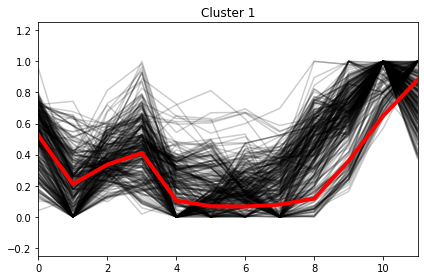

In [18]:
k = 0 # Put index of cluster
for xx in indo_scaled[y_pred == k]:
    plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, 11)
    plt.ylim(-0.25, 1.25)
    
plt.plot(sdtw_km.cluster_centers_[k].ravel(), "r-",linewidth=4)
plt.title("Cluster 1")

plt.tight_layout()
plt.show()

Cluster 1 represents the rain pattern which has two peaks in March and October.

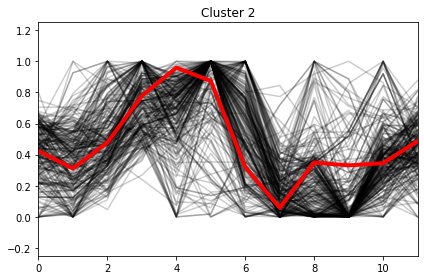

In [19]:
k = 1 # Put index of cluster
for xx in indo_scaled[y_pred == k]:
    plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, 11)
    plt.ylim(-0.25, 1.25)
    
plt.plot(sdtw_km.cluster_centers_[k].ravel(), "r-",linewidth=4)
plt.title("Cluster 2")

plt.tight_layout()
plt.show()

Cluster 2 represents the rain which only have one peak and occurs in the middle of the year.

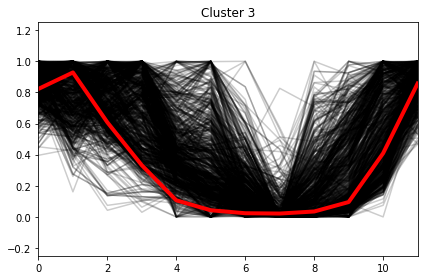

In [20]:
k = 2 # Put index of cluster
for xx in indo_scaled[y_pred == k]:
    plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, 11)
    plt.ylim(-0.25, 1.25)
    
plt.plot(sdtw_km.cluster_centers_[k].ravel(), "r-",linewidth=4)
plt.title("Cluster 3")

plt.tight_layout()
plt.show()

Cluster 3 represents the monsoonal rainfall pattern which has the peak of rainy season in December-Jauary-February and the lowest of rain amount in June-July-August.

In [292]:
indo_scaled[y_pred==0].shape[0],indo_scaled[y_pred==1].shape[0],indo_scaled[y_pred==2].shape[0]

(820, 254, 349)

**Get the optimal k**

In [188]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
    km = km.fit(indo_scaled)
    Sum_of_squared_distances.append(km.inertia_)

0.273 --> 0.162 --> 0.162 --> 0.161 --> 0.162 --> 0.162 --> 0.162 --> 0.162 --> 0.162 --> 0.162 --> 0.162 --> 0.162 --> 0.162 --> 0.162 --> 0.162 --> 0.162 --> 0.162 --> 0.162 --> 0.162 --> 0.162 --> 
0.110 --> 0.056 --> 0.052 --> 0.051 --> 0.051 --> 0.051 --> 0.051 --> 0.051 --> 0.050 --> 0.050 --> 0.050 --> 0.050 --> 0.050 --> 0.050 --> 0.050 --> 0.050 --> 0.050 --> 0.050 --> 0.049 --> 0.049 --> 0.050 --> 0.049 --> 0.050 --> 0.049 --> 0.049 --> 0.049 --> 0.049 --> 0.049 --> 0.049 --> 0.049 --> 0.049 --> 0.049 --> 0.049 --> 0.049 --> 0.049 --> 0.049 --> 0.049 --> 0.049 --> 0.049 --> 
0.060 --> 0.033 --> 0.031 --> 0.030 --> 0.030 --> 0.030 --> 0.030 --> 0.030 --> 0.030 --> 0.030 --> 0.030 --> 0.030 --> 0.030 --> 
0.043 --> 0.024 --> 0.024 --> 0.024 --> 0.024 --> 0.024 --> 0.024 --> 0.024 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 
0.039 --> 0.020 --> 0.018 --> 0.017 --> 0.017 --> 0.017 --> 0.017 --> 0.017 --> 0.017 --> 0.017 --> 0.017 

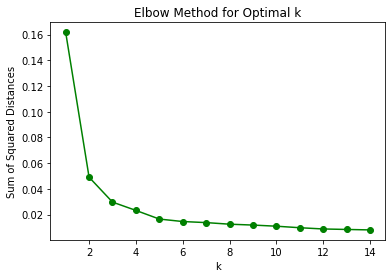

In [193]:
plt.plot(K, Sum_of_squared_distances, 'go-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

Using elbow method, the optimum k is K=3.